# The Multi-Armed Bandit Problem

### Using DRL on the multi armed bandit problem to get a better understanding before applying it to MSA

A brief description of the problem: You are faced repeatedly with a choice among k different options, after each choice you receive a numerical reward chosen from a stationary probability distribution that depends on the action you selected. Your objective is to maximise the expected total reward over some time period

We denote the action selected on time step $t$ as $A_t$ and the corresponding reward as $R_t$. The value of a arbitrary action $a$, denoted $q_*(a)$, is the expected reward given that a is selected:  

$\large q_*(a) = E[R_t | A_t = a]$


### methods for estimating the value of actions and for using the estimates to make action selection decision, known as action-value methods

The true value of an action is the mean reward when that action is selected. One natural way to estimate this is by averaging the rewards actually received

$\large Q_*(t) = \frac{\text{sum of rewards when $a$ taken prior to $t$}}{\text{number of times $a$ taken prior to $t$}}$

To illustrate this problem in code we first begin by importing some necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

2023-10-22 17:22:09.783965: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-22 17:22:10.158707: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-22 17:22:10.158747: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-22 17:22:10.161090: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-22 17:22:10.351699: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-22 17:22:10.353524: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

## Bandit Class Definition

We define the `Bandit` class to contain the following attributes and methods that carry specific information and functionality related to the k-armed bandit problem:

1. **Number of Arms:**  
   An attribute to store and manage the number of available actions or arms.
   
2. **True Values of Actions:**  
   An array to represent the true values of selecting each action, often denoted as $q_*(a)$ for action $a$.

3. **Estimated Values of Actions:**  
   Initially set to 0, this array, often denoted as $Q_t(a)$, stores the estimated value of each action $a$ as time    $t$ progresses.

4. **Action Counts:**  
   An array that keeps track of the number of times each action \( a \) has been selected up to time \( t \).

5. **Update Function:**  
   A method that employs the following update rule to adjust the estimated values based on received rewards:
   $
   Q_{n+1} = Q_n + \alpha [R_n - Q_n]
   $
  

6. **Reward Function:**  
   A method to compute the reward for a selected action, typically modeled as a stochastic process following a certain probability distribution.


Note the update function we are using is written more simply as:  
$NewEstimate \leftarrow OldEstimate + StepSize [Target - OldEstimatei]$  
$NewEstimate$ is $Q_{n+1}$  
$OldEstimate$ is $Q_n$  
$StepSize$ is $\alpha$  
$Target$ is $R_n$  

In [2]:
class Bandit:
    def __init__(self, k):
        self.k = k  # Number of arms
        self.action_values = np.random.randn(k)  # True values of actions
        self.estimated_values = np.zeros(k)  # Estimated values of actions, initially all 0
        self.action_counts = np.zeros(k)  # Counts of the selected actions
    
    def get_reward(self, action):
        return np.random.randn() + self.action_values[action]
    
    def update_estimate(self, action, reward):
        self.action_counts[action] += 1
        self.estimated_values[action] += (reward - self.estimated_values[action]) / self.action_counts[action]


Note that for our ``get_reward function``, ``action_values[action]`` is the median of the probability distribution, we then add a random number between -1 and 1, this probability distribution for the reward is based off of the probability distribution shown in the RL book:
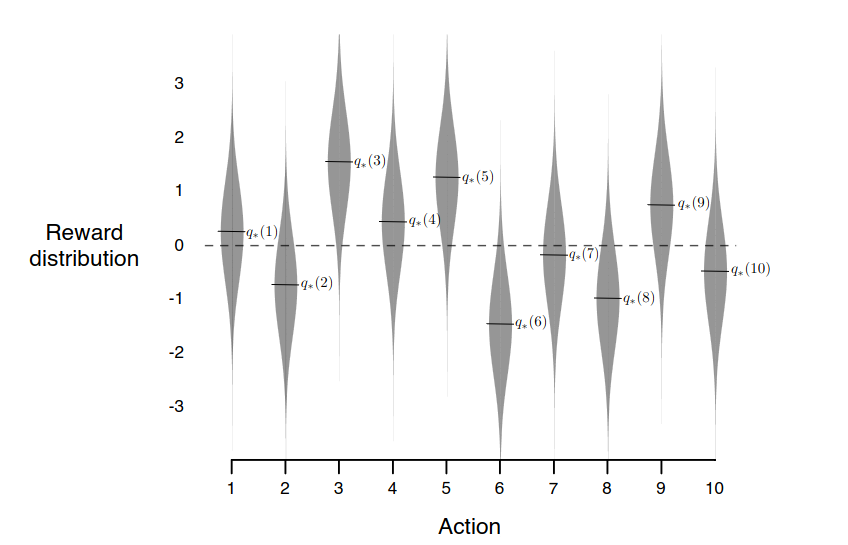

Now we need our policy, we will be using the **epsilon greedy** policy, this policy selects the best immediate action with probability of $1 - \epsilon$ (exploitation), and selects a random action with probability $\epsilon$ (exploration)

In [3]:
def epsilon_greedy(epsilon, estimated_values):
    if np.random.rand() < epsilon:
        return np.random.randint(len(estimated_values))  # Explore
    else:
        return np.argmax(estimated_values)  # Exploit

Now we can write our function to simulate the bandit problem

In [4]:
def simulate_bandit(k, epsilon, steps):
    bandit = Bandit(k)
    total_reward = 0
    average_rewards = []

    for step in range(steps):
        action = epsilon_greedy(epsilon, bandit.estimated_values)
        reward = bandit.get_reward(action)
        bandit.update_estimate(action, reward)
        total_reward += reward
        average_rewards.append(total_reward / (step + 1))
    
    return average_rewards


Now defining some parameters for running our simulation

In [5]:
# Parameters
k = 10  # Number of arms
epsilon = 0.8  # Exploration probability
steps = 1000  # Number of steps in each run
runs = 10  # Number of runs

Now in the code below we create an array ``avg_rewards`` to store the reward we were given at each time step for each run, we then divide it by the number of runs which gives us the average over all the runs, we can then use this information to plot a graph

In [6]:
avg_rewards = np.zeros(steps)
for run in range(runs):
    avg_rewards += simulate_bandit(k, epsilon, steps)
avg_rewards /= runs

The graph displayed below shows how the average reward changed over the amount of steps, each point is the reward given at that particular step, we also run it multiple times and take the average reward at that step for the point. We can see that using the $\epsilon$-greedy policy the average reward improves over the number of steps taken. We can see with 1 run the line is a lot more "jagged" but with more runs the lines smoothens out

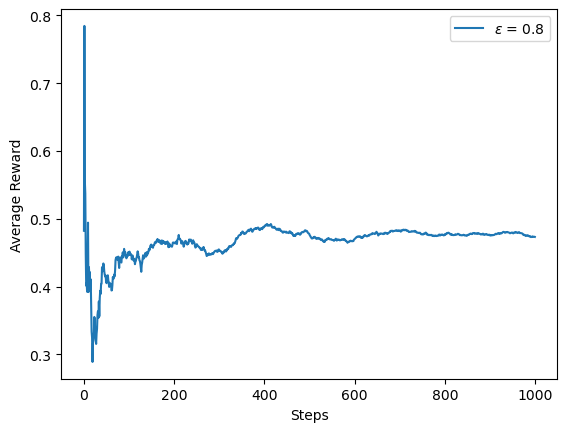

In [7]:
plt.plot(avg_rewards, label=f"$\epsilon$ = {epsilon}")
plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.legend()
plt.show()

Lets attempt to implement a DNN into our bandit to predict our action values, first we need to modify the class.

In [8]:
class DeepBandit:
    def __init__(self, k):
        self.k = k  # Number of arms
        self.model = self._build_model()
        self.action_values = np.random.randn(k)  # True values of actions for comparison purposes
        self.estimated_values = np.zeros(k)  # Estimated values of actions, initially all 0
        self.action_counts = np.zeros(k)  # Counts of the selected actions
        
    def _build_model(self):
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Dense(10, activation='relu', input_shape=(1,)))
        model.add(tf.keras.layers.Dense(self.k, activation='linear'))
        model.compile(optimizer='adam', loss='mean_squared_error')
        return model
    
    def get_action_values(self, state):
        return self.model.predict(np.array([state]))[0]
    
    def train(self, state, action, reward):
        target = self.get_action_values(state)
        target[action] = reward  # use the observed reward as the target for the selected action
        self.model.train_on_batch(np.array([state]), np.array([target]))

    
    def get_reward(self, action):
        return np.random.randn() + self.action_values[action]
    
    def update_estimate(self, action, reward):
        self.action_counts[action] += 1
        self.estimated_values[action] += (reward - self.estimated_values[action]) / self.action_counts[action]


Next we need to change our ``simulate_bandit`` function

In [9]:
def simulate_bandit(k, epsilon, steps):
    bandit = DeepBandit(k)
    total_reward = 0
    average_rewards = []

    for step in range(steps):
        action_values = bandit.get_action_values(1)  # state is not really used, it's just a placeholder here
        action = epsilon_greedy(epsilon, action_values)
        reward = bandit.get_reward(action)
        bandit.train(1, action, reward)
        total_reward += reward
        average_rewards.append(total_reward / (step + 1))

    return average_rewards

Now we can try running again

In [10]:

# Parameters
k = 10  # Number of arms
epsilon = 0.8  # Exploration probability
steps = 100  # Number of steps in each run
runs = 1  # Number of runs

avg_rewards = np.zeros(steps)
for run in range(runs):
    avg_rewards += simulate_bandit(k, epsilon, steps)
avg_rewards /= runs

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


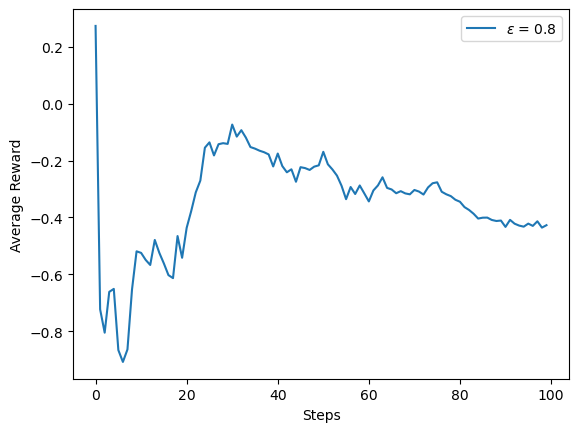

In [14]:
plt.plot(avg_rewards, label=f"$\epsilon$ = {epsilon}")
plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.legend()
plt.show()

Lets try using a different policy as the $\epsilon$ greedy policy does sometimes explore but the exploration is random, lets try and explore based on the potential of a certain action using Upper-Confidence-Bound Action Selection